{'eval_method': '3_fold', 'model_name': 'llama3.2:3b-instruct-fp16'}
['syntax' 'semantic' 'tests']
                  category  count  percentage
0  Symbol Resolution Error    304   43.428571
1    Type Resolution Error    190   27.142857
2       Invalid connection    154   22.000000
3         Duplicate symbol     28    4.000000
4     Other Semantic Error     14    2.000000
5  Invalid function header     10    1.428571


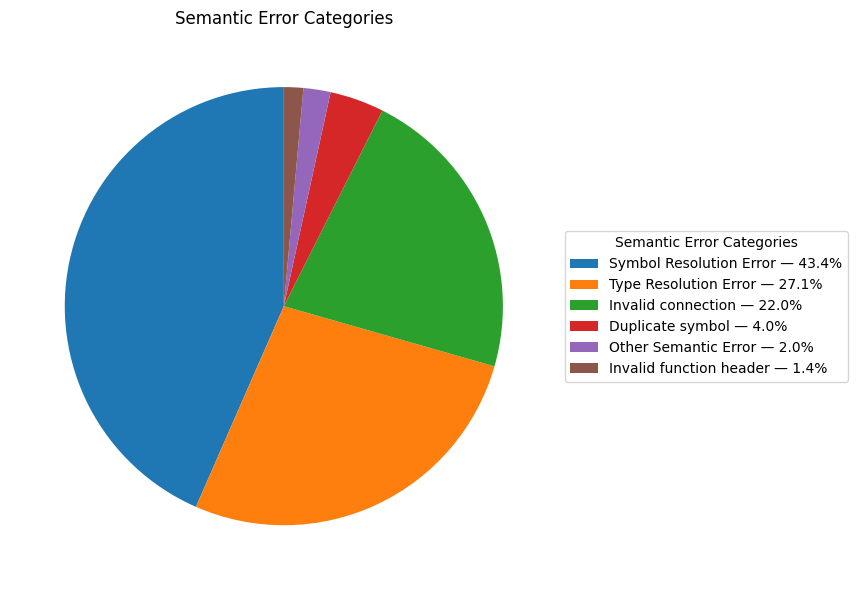

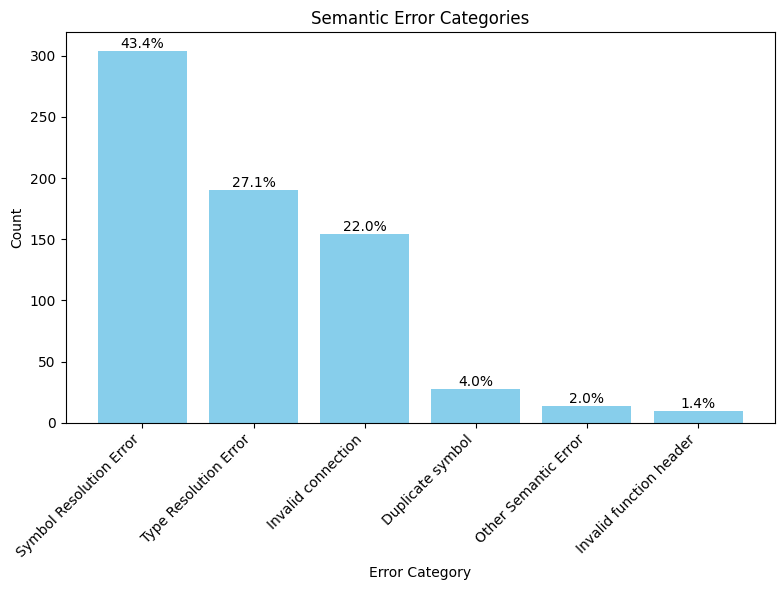

,created_at,task_id,error_type,semantic_category,semantic_error,test_result,stderr,stdout,code_candidate
50,2025-04-07 21:23:23.770,8,semantic,"{Symbol Resolution Error, Type Resolution Error}","[Unable to resolve type (root.Std_k98bjb.Math.GreaterThan) for instance (greaterthan_f4e2c9), perhaps it has been removed.]",None,,"Installing dependencies for midio_example@0.1.0\n\nNo external dependencies\n\nBuilding package...\n[31mERROR[0m [2mcompiler::frontend::semantic_analysis::analyzers::instance_analyzer[0m[2m:[0m [2m83:[0m Failed to resolve path: Failed to resolve symbol: root.Std_k98bjb.Math.GreaterThan\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1341:[0m Model has errors:\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1343:[0m SemanticAnalysisError(@94): Unable to resolve type (root.Std_k98bjb.Math.GreaterThan) for instance (greaterthan_f4e2c9), perhaps it has been removed., backtrace: 0: <unknown>\n 1: <unknown>\n 2: <unknown>\n 3: <unknown>\n 4: <unknown>\n 5: <unknown>\n 6: <unknown>\n 7: <unknown>\n 8: <unknown>\n 9: <unknown>\n 10: <unknown>\n 11: <unknown>\n 12: <unknown>\n 13: <unknown>\n 14: <unknown>\n 15: <unknown>\n 16: <unknown>\n 17: <unknown>\n 18: <unknown>\n 19: <unknown>\n 20: <unknown>\n 21: <unknown>\n 22: __libc_start_main\n 23: <unknown>\n\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1360:[0m Model has errors, skipping code generation\nPackage built successfully!","import(""std"", Std_k98ojb)\nimport(""http"", Http_q7o96c)\n\nmodule() main { \n func(doc: ""check whether the entered number is greater than the elements of the given array."") check_greater {\n in(x: -33, y: -26, name: ""n"") property(Number) n_a6cea7\n in(x: -294, y: 155, name: ""list"") property(Any) list_0b075e\n\n out(x: 546, y: 63, name: ""output"") property(Bool) output_b1d7f8\n\n instance(x: 15, y: 6) for_8cb3f6 root.Std_k98ojb.Std.For {}\n instance(x: -21, y: 142) greaterthan_f4e2c9 root.Std_k98bjb.Math.GreaterThan {}\n list_0b075e -> for_8cb3f6.items\n n_a6cea7 -> for_8cb3f6.index\n for_8cb3f6.onItem -> greaterthan_f4e2c9.left\n 0 -> greaterthan_f4e2c9.right\n greaterthan_f4e2c9.result -> output_b1d7f8\n }\n\n \n\n instance(x: -98, y: -73) check_greater_6a3b5 root.main.check_greater {}\n}"
52,2025-04-07 21:23:23.770,8,semantic,{Invalid connection},[Arrow from Trigger to Property is not allowed],None,,"Installing dependencies for midio_example@0.1.0\n\nNo external dependencies\n\nBuilding package...\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1341:[0m Model has errors:\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1343:[0m SemanticAnalysisError(@161): Arrow from Trigger to Property is not allowed, backtrace: 0: <unknown>\n 1: <unknown>\n 2: <unknown>\n 3: <unknown>\n 4: <unknown>\n 5: <unknown>\n 6: <unknown>\n 7: <unknown>\n 8: <unknown>\n 9: <unknown>\n 10: <unknown>\n 11: <unknown>\n 12: <unknown>\n 13: <unknown>\n 14: <unknown>\n 15: <unknown>\n 16: <unknown>\n 17: <unknown>\n 18: <unknown>\n 19: <unknown>\n 20: <unknown>\n 21: <unknown>\n 22: __libc_start_main\n 23: <unknown>\n\n[31mERROR[0m [2mcompiler::frontend::compiler_pass[0m[2m:[0m [2m1360:[0m Model has errors, skipping code generation\nPackage built successfully!","import(""std"", Std_k98ojb)\nimport(""http"", Http_q7o96c)\n\nmodule() main { \n func(doc: ""check whether the entered number is greater than the elements of the given array."") check_greater {\n in(x: -33, y: -26, name: ""n"") property(Number) n_a6cea7\n\n in(x: -294, y: 155, name: ""list"") property(Any) list_0b075e\n\n out(x: 546, y: 63, name: ""output"") property(Bool) output_b1d7f8\n\n instance(x: 15, y: 6) greaterthan_f9c5a2 root.Std_k98ojb.Math.GreaterThan {}\n instance(x: -37, y: 71,) for_8cb3f6 root.Std_k98ojb.Std.For {}\n instance(x: 23, y: 56) ifexpression_a2fa90 root.Std_k98ojb.Std.IfExpression {\n expression: ""a > n""\n }\n instance(x: -28, y: 63,)

In [2]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "few_shot_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_bar_chart, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

experiment_name = f"signature_similarity_5_shot"
error_type = "semantic"
filter = {
    "eval_method": "3_fold",
    "model_name": "llama3.2:3b-instruct-fp16",
}
# Categorize and extract errors:
df = errors_to_df(experiment_name, filter=filter)
df["syntax_error"] = df["stderr"]
df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

df["tests_category"] = df["test_result"].apply(categorize_test_errors)
df["tests_error"] = df.apply(
    lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
    axis=1
)

filtered_df = df[
    (df["error_type"] == error_type) #&
    # (df[f"{error_type}_category"] == {'Invalid function header'})
][[
    "created_at",
    "task_id", 
    "error_type",
    f"{error_type}_category", 
    f"{error_type}_error", 
    "test_result",
    # "error_msg", 
    "stderr", 
    "stdout",
    "code_candidate"
]]


# Show all rows
pd.set_option('display.max_rows', None)     

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each cell
pd.set_option('display.max_colwidth', None)

print(df["error_type"].unique())


errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
print(errors_count_df)

make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")


filtered_df.head(10)

